### Задача на Симплекс метод

#### 1) На вход Вашей функцию должны приходить:

0. число переменных = n
1. матрица A (n x m) (tsv, вещественные числа)
2. вектор  b  ограничений типа неравнство
4. вектор c функции полезности для задачи max cx 
5. алгоритм выбора входящей переменной (правило Бленда, Лексикографический метод)
6. (не обязательный параметр) стартовую базисную точку

#### 2) На выход программа должна выдавать:

#### Обязательная часть (0.7 баллов):
0. Ответ и оптимальную точку при положительных компонентах вектора b
1. Количество итераций потребовавшихся для решения задачи
2. при n=2 выдавать процесс решения (draw=True)
3. Напишите программу которая будет отвечать на вопрос оптимально ли приведенное решение, например


#### Дополнительная часть  (0.4 балл):
0. Максимально использовать матричные вычисления (0.2 балла)
1. Работать в случае отрицательных чисел в векторе b (0.2 балла)




In [919]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

%matplotlib inline

Для представления симплекс таблиц используется tableau, имеющая вид:

$$   
        \left(\begin{array}{cc}  
           A & I & b\\  
           c & 0 & 0
        \end{array}\right)
$$

Переход к новому базису происходит с помощью матрицы Гаусса:
$$   
        \left(\begin{array}{cc}  
           I_{s \times s} & -\alpha^{-1}a & 0\\  
           0 & -\alpha^{-1} & 0\\
           0 & -\alpha^{-1}b & I_{t \times t}
        \end{array}\right)
$$

где вектор 
$$   
        \left(\begin{array}{cc}  
           a\\
           \alpha\\
           b
        \end{array}\right)
$$ расположен в столбце входящей переменной, а $\alpha$ стоит на пересечении этого стобца и строки ограничения, из которой определяется уходящая переменная. 


In [920]:
def SimplexAlgorithm(A, b, c, method='blend', start_point=None, draw=False):
    """
    method - 'blend', 'lexical'
    start_point - точка
    """
    num_iters = 0
    solution_found = False
    unbounded = False
    
    if start_point is None:
        start_point = np.zeros(len(c))
    
    #для сохранения промежуточных допустимых решений
    points = []
    points.append(start_point)
    
    tableau = ConstructInitialTableau(A, b, c)
    if NegativeConstraints(b):
        tableau = ConvertToStandardForm(tableau, b)
        print(tableau)
    
    while not solution_found:
        i = FindPivotColumn(tableau[-1, :])
        
        if i is None:
            solution_found = True
            continue
            
        j = FindPivotRow(tableau[:, i], tableau[:, -1])
        if (j is None):
            print("Unbounded optimum \n")
            unbounded = True
            break
                
        G = MakeGaussianMatrix(tableau[:, i], j)
        
        tableau = np.dot(G, tableau)
        
        points.append(FindSolution(tableau, len(c)))
        num_iters += 1
    
    if not unbounded:
        result = (-1) * tableau[-1, -1]
        optimal_solution = points[-1]
    
        if draw and len(c) == 2:
            DrawSolution(A, b, points, num_iters)
      
        return optimal_solution, result, num_iters
    else:
        return None, None, None

In [921]:
def ConstructInitialTableau(A, b, c):
    tableau = np.c_[A, np.eye(A.shape[0])]
    tableau = np.c_[tableau, b]
    c = np.append(c, np.zeros(A.shape[0] + 1))
    tableau = np.r_['0,2', tableau, c]
    
    return tableau

In [922]:
def NegativeConstraints(b):
    i = np.amin(b)
    if (i < 0):
        return True
    else:
        return False

In [923]:
 def ConvertToStandardForm(tableau, b):
    tableau[-1, :] = 0
    
    for i in range(0, len(b)):
        if (b[i] < 0):
            tableau[i, :] = -tableau[i, :]
    
    return tableau

In [924]:
#ищем входящую переменную
def FindPivotColumn(data):
    i = np.argmax(data[0:-1])
    if data[i] <= 0:
        i = None
    return i

In [925]:
#ищем выходящую переменную
def FindPivotRow(pivot_column, b):
    pivot_column = pivot_column[0:-1]
    b = b[0:-1]
    n = b.shape[0]
    
    borders = np.empty(n)
    
    for i in range(0, n):
        if (pivot_column[i] > 0):
            borders[i] = b[i] / pivot_column[i]
        else:
            borders[i] = 0
    
    j = None
    for i in range(0, n):
        if borders[i] != 0 and (j is None or borders[j] > borders[i]):
            j = i
            
    return j

In [926]:
#составляем матрицу для перехода к новому базису
def MakeGaussianMatrix(v, j):
    alpha = v[j]
    a = (-1) * v[0:j] / alpha
    b = (-1) * v[j+1:] / alpha
    s = a.shape[0]
    t = b.shape[0]

    G = np.c_[np.eye(s), a]
    G = np.c_[G, np.zeros((s, t))]
    
    second_block = np.zeros(s + t + 1)
    second_block[s] = 1 / alpha
    
    if s != 0:
        G = np.r_['0,2', G, second_block]
    else:
        G = second_block
    
    third_block = np.zeros((t, s))
    third_block = np.c_[third_block, b]
    third_block = np.c_[third_block, np.eye(t)]
    
    G = np.r_['0,2', G, third_block]
    
    return G

In [927]:
#ищем оптимальное решение по оптимальной симплекс-таблице
def FindSolution(tableau, n):
    #массив решений - все 0, т.к. не базисные переменные - 0
    solution = np.zeros(n)
    
    #ищем базисные элементы, они входят с коэффициентом 0 в z
    for i in range(0, n):
        if tableau[-1, :][i] == 0:
            solution[i] = -1
    
    #меняем значения базисных переменных на свободный коэффициент
    for i in range(0, n):
        if solution[i] != 0:
            index_of_unit = np.argmax(tableau[:, i][0:-1])
            solution[i] = tableau[index_of_unit, -1]
    
    return solution


In [928]:
def DrawSolution(A, b, points, num_iters):
    fig, ax= plt.subplots(num_iters + 1)
    fig.set_figheight(5 * (num_iters + 1))
    fig.set_figwidth(5)

    for i,a in enumerate(ax):
        for j in range( len(b) ):
            a.plot([0,17],[b[j]/A[j][1],(b[j] - 17 * A[j][0])/A[j][1]],  color='b')
            if A[j][0] == 0:
                grid = np.arange(0, 17, 0.01)
                right = np.ones(len(grid)) * b[j]/A[j][1]
                a.fill_between(grid, 0, right, color='red', alpha=0.15)
                continue
            if A[j][1] == 0:
                grid = np.arange(0, b[j]/A[j][0], 0.01)
                a.fill_between(grid, 0, 17, color='red', alpha=0.15)
                continue
            if A[j][1] > 0:
                grid = np.arange(0, b[j]/A[j][0], 0.01)
                right = (b[j] - A[j][0] * grid) / A[j][1]
                a.fill_between(grid, 0, right, color='red', alpha=0.15)
                continue
            if A[j][1] < 0:
                grid = np.arange(0, 17, 0.01)
                right = (b[j] - A[j][1] * grid) / A[j][0]
                a.fill_betweenx(grid, 0, right, color='red', alpha=0.15)
                
        a.plot([0,17],[0,0], color='b')
        a.plot([0,0],[0,17], color='b')
            
        # рисуем точки
        a.scatter(points[i][0], points[i][1], color="red", s=64)
            
        a.axis([-1, 17, -1, 17])
            
        # подписываем оси и график
        a.set_xlabel('X1')
        a.set_ylabel('X2')
        a.set_title('Iteration %d: x=(%.2f, %.2f)' % (i, points[i][0], points[i][1]))

    plt.tight_layout()
    plt.show()

In [929]:
def IsOptimal (A, b, c, x):
    """
    Здесь должна быть реализована проверка оптимальности точки. 
    Алгоритм должен работать для фиксированных n,m за константное время
    """
    point = solve_lin_prog(A,b,c)[0]
    for i in range(len(c)):
        if point[i] != x[i]:
            return False
    return True

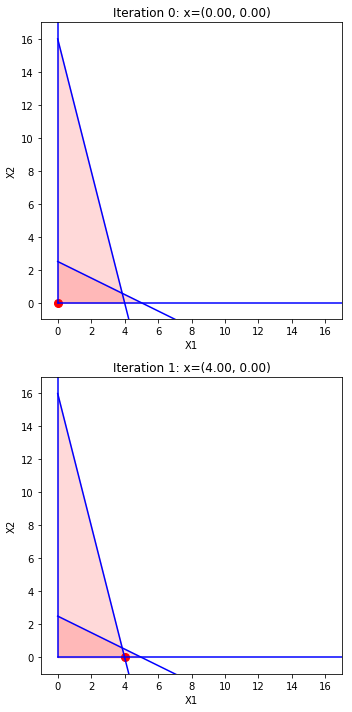

Точка:  [ 4.  0.]
Ответ:  20.0
Число итераций:  1




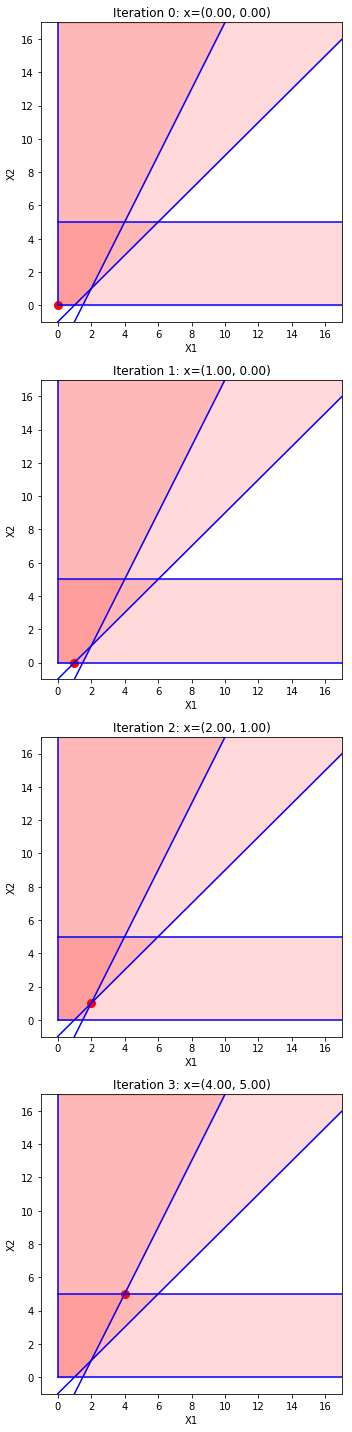

Точка:  [ 4.  5.]
Ответ:  31.0
Число итераций:  3


Точка:  [ 2.  0.  1.]
Ответ:  13.0
Число итераций:  2


Точка:  [ 4.  0.  1.]
Ответ:  8.0
Число итераций:  2


[[ 1. -1. -1. -0. -0.  1.]
 [ 1.  2. -0. -1. -0.  2.]
 [ 0.  1.  0.  0.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.]]
Точка:  [ 0.  0.]
Ответ:  -0.0
Число итераций:  0




In [930]:
#Примеры работы симплекс алгоритма

A = np.array([[1,2],[2,0.5]])
b = np.array([5,8])
c = np.array([5,1])
# [ 4.  0.] 20.0 1
x, best, n_iter = SimplexAlgorithm(A,b,c, draw=True)
print (u'Точка: ', x)
print (u'Ответ: ', best)
print (u'Число итераций: ', n_iter)
print('\n')

A = np.array([[1, -1], [2,-1], [0, 1]])
b = np.array([1, 3, 5])
c = np.array([4, 3])
x, best, n_iter = SimplexAlgorithm(A,b,c, draw=True)
#[ 4.  5.] 31.0 3
print (u'Точка: ', x)
print (u'Ответ: ', best)
print (u'Число итераций: ', n_iter)
print('\n')

A = np.array([[2, 3, 1], [4, 1, 2], [3, 4, 2]])
b = np.array([5, 11, 8])
c = np.array([5, 4, 3])
#[ 2.  0.  1.] 13.0 2
x, best, n_iter = SimplexAlgorithm(A,b,c, draw=False)
print (u'Точка: ', x)
print (u'Ответ: ', best)
print (u'Число итераций: ', n_iter)
print('\n')

A = np.array([[1, 4, 0], [2, 4, -2], [1, 1, -2]])
b = np.array([5, 6, 2])
c = np.array([3, 2, -4])
#[ 4.  0.  1.] 8.0 2
x, best, n_iter = SimplexAlgorithm(A,b,c, draw=False)
print (u'Точка: ', x)
print (u'Ответ: ', best)
print (u'Число итераций: ', n_iter)
print('\n')

A = np.array([[-1, 1], [-1, -2], [0, 1]])
b = np.array([-1, -2, 1])
c = np.array([-2, -1])
# unbounded
x, best, n_iter = SimplexAlgorithm(A,b,c, draw=False)
print (u'Точка: ', x)
print (u'Ответ: ', best)
print (u'Число итераций: ', n_iter)
print('\n')



In [931]:
def IsOptimal (A,b,c,x):
    return True

### Задача на МНК

### Задание 1 (0.2 балла)
1.	Постройте в одной координатной плоскости графики у(t, a) и  оценочные значения y(t,a*) для всех 3 методов

2.	Вычислите как отличается каждый из оценочных параметров от своего истинного значения. Как меняется это отличие при изменении σ?
3.	Скорректируйте y_corr[0]  и y_corr[-1] пусть одно из них будет на 50 больше, а другое на 50 меньше. Постройте новые оценочные значения параметров  и соответствующие графики. Какая из оценок получилась более устойчивой к выбросам?

### Задание 2 (0.2 балла)
Возьмем случайную матрицу A  200x80 и случайный вектор b из распределения N(0,1). 

1. Решите переопределенную систему тремя способами, минимизируя l1, l2 и linf нормы вектора b – Ax.
2. Постройте распределение ошибок для каждого решения.
3. Какими свойствами обладают распределения?

In [932]:
from math import sin

"""Пусть физический закон описывается зависимостью 
некоторого измеряемого значения y(x, a) 
от времени и координаты x при параметрах a:"""
def y(t, a): 
    return a[2] * sin(t) + a[1] * t + a[0]

"""Результаты измерений отличаются от истинных значений в силу действия случайной аддитивной помехи 
(случайность подчиняется нормальному закону распределения N(0, σ))"""
def get_y_true(t, a):
    y_true = np.array([y(i, a) for i in t])
    return y_true

def get_y_corr(y_true, t, sigma):
    y_corr = y_true + np.random.normal(0, sigma, len(t))
    return y_corr
    
"""
Дан набор координат t размера m, значения распределены равномерно. Пусть m = 200.
"""
m = 200
t = [i * 10.0 / m for i in range(m)]

"""Для каждого момента времени t сгенерируйте соответствующее 
значение y(t,a) при некоторых параметрах  a_0, a_1, a_2. Для примера: """
a_true = np.array([2, 0.2, 0.4])
sigma = 0.2

#генерация значений: изначальные и с помехами
y_true = get_y_true(t, a_true)
y_corr = get_y_corr(y_true, t, sigma)

In [933]:
def get_params (y_corr, t, method):
    if method == 0:
        return method_0(y_corr, t)
    elif method == 1:
        return [2, 0.2, 0.4]
    elif method == 2:
        return [2, 0.2, 0.4]

In [934]:
#method = 0 -> сумма квадратов невязок будет минимальна.
def method_0 (y_corr, t):
    A = np.array([[1, i, sin(i)] for i in t])
    a_est = np.dot(np.dot(np.linalg.inv(np.dot(A.transpose(), A)), A.transpose()), y_corr)
    return a_est

In [935]:
#method = 1 -> сумма абсолютных значений невязок будет минимальна
def method_1(y_corr, t):
    A = np.array([[1, i, sin(i)] for i in t])
    E = np.eye(len(t))
    B = np.bmat([[A, -E], [-A, -E]])
    
    b = y_corr
    b = np.append(b, -y_corr)
    
    c = np.ones(len(t))
    c = np.append(np.zeros(3), -c)
    
    x, best, n_iter = SimplexAlgorithm(B, b, c)
    print (u'Точка: ', x)
    print (u'Ответ: ', best)
    print (u'Число итераций: ', n_iter)
    
    return best

In [936]:
#method = 2 -> максимальное абсолютное значение невязки будет минимально
def method_2(y_corr, t):
    
    return a_est

Метод 1 и 2 должны использовать SimplexAlgorithm, где возомжно b < 0

In [937]:
a_est = []
for i in range(3):
    a_est.append(get_params(y_corr, t, i))

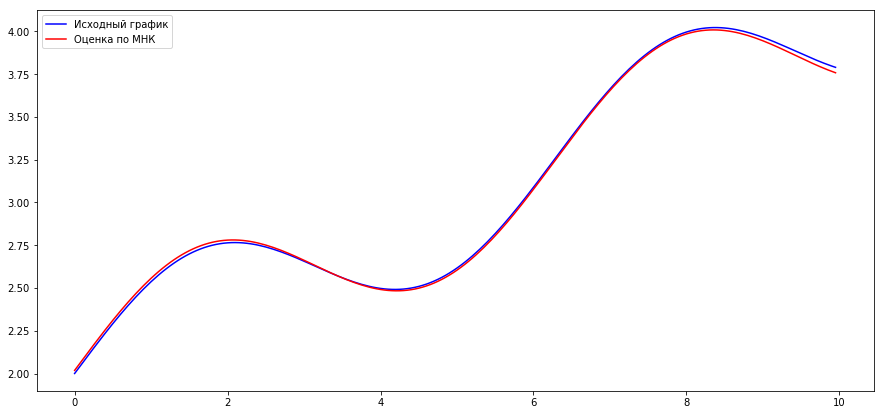

In [938]:
plt.figure(figsize=(15, 7))
plt.plot(t, y_true, color="blue", label="Исходный график")
plt.plot(t, get_y_true(t, a_est[0]), color="red", label="Оценка по МНК")
plt.legend()

plt.show()

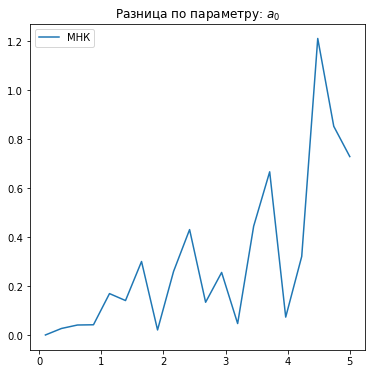

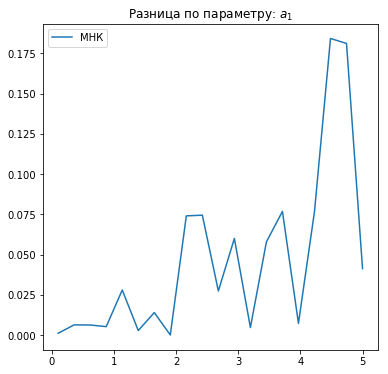

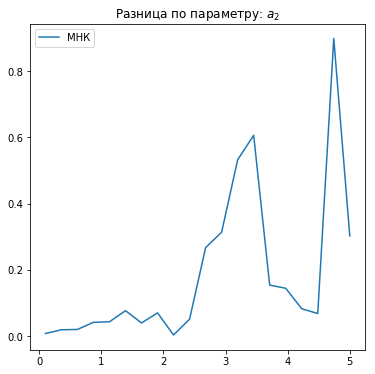

In [939]:
diff_0 = [[], [], []]
sigmas = np.linspace(0.1, 5, 20)
for i in range(0, len(sigmas)):
    y_corr = get_y_corr(y_true, t, sigmas[i])
    a_est = method_0(y_corr, t)
    
    for j in range(3):
        diff_0[j].append(np.abs(a_est[j] - a_true[j]))

for i in range(3):
    plt.figure(figsize=(6, 6))
    plt.plot(sigmas, diff_0[i], label="МНК")
    plt.legend()
    plt.title("Разница по параметру: $a_%d$" % i)
    plt.show()